In [1]:
# based on https://quantum-computing.ibm.com/services/programs/docs/runtime/manage/systems/dynamic-circuits/Getting-started-with-Dynamic-Circuits
print('started2')

started2


In [3]:
import qiskit.tools.jupyter
%qiskit_version_table

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k
OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k
OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [4]:
# Running checks for the correct dependencies
import qiskit
from packaging import version

if not(version.parse(qiskit.__qiskit_version__["qiskit-terra"]) >= version.parse("0.22")):
    print(
        "Incorrect dependencies. Found qiskit-terra: "
        + qiskit.__qiskit_version__["qiskit-terra"]
        + "\nNeed qiskit-terra >= 0.22"
    )

    print(
        "You must install the qiskit_ibm_provider with 'pip install qiskit_ibm_provider'"
    )
else:
    print('PASSED')

PASSED


In [5]:
# Ignoring warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
! /dataVault/activate_IBMProvider.py # activates my IBMQ credencials

In [27]:
# Testing OpenQASM 3 support
# Note: This can be any hub/group/project that has access to the required device and the Qiskit runtime.
hub = 'ibm-q-ornl'
group = "lbnl"
project = "chm170"
backend_name = "ibmq_jakarta"
backend_name = "ibmq_manila"
hgp = f"{hub}/{group}/{project}"
print('hgp:',hgp)

hgp: ibm-q-ornl/lbnl/chm170


In [28]:
import qiskit
from qiskit_ibm_provider import IBMProvider
# Save token if necessary
#IBMProvider.save_account(token=myToken)
 
# Get our backend
provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)
print('\nmy backend=',backend)


my backend= <IBMBackend('ibmq_manila')>


In [29]:
# Make sure to use any OpenQASM 3-enabled backend.
qasm3_backends = set(
    backend.name for backend in provider.backends(dynamic_circuits=True)
)

print(f"The following backends support dynamic circuits: {qasm3_backends}")

The following backends support dynamic circuits: {'ibmq_kolkata', 'ibm_sherbrooke', 'ibmq_manila', 'ibmq_jakarta', 'ibm_oslo', 'ibm_geneva', 'ibm_auckland', 'ibmq_mumbai', 'ibm_washington', 'ibm_nairobi'}


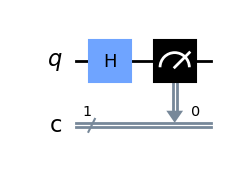

In [30]:
#Now we prepare our circuit.
qubit = 0
shots = 2000
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

h_qc = QuantumCircuit(1, 1, name="|+> Prep")
h_qc.h(0)
h_qc.measure(0, 0)
h_qc.draw(idle_wires=False, output="mpl")

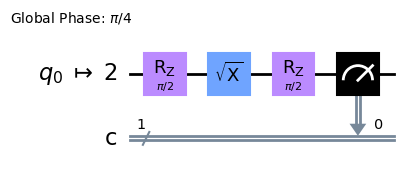

In [31]:
#Next, transpile our quantum circuit for the hardware basis gates. 
from qiskit import transpile

h_qc_transpiled = transpile(h_qc, backend, initial_layout=[2])
h_qc_transpiled.draw(idle_wires=False, output="mpl")

In [32]:
#Note that we have to set dynamic=True to communicate to the backend that we want to run a dynamic circuit.
job = backend.run(h_qc_transpiled, shots=shots, dynamic=True)
print(f"Your job's id:%s on backend=%s"%(job.job_id(),backend))
result = job.result()
print(f"|+> preparation results: {result.get_counts(0)}")

Your job's id:cfm3ktjm6bfvlaha2q2g on backend=<IBMBackend('ibmq_manila')>
|+> preparation results: {'0': 531, '1': 469}


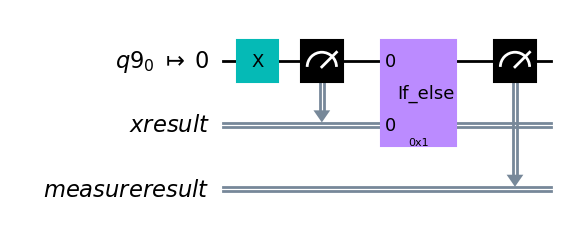

In [35]:
# Step 2: Write a dynamic circuit with Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
qr = QuantumRegister(1)
crx = ClassicalRegister(1, name="xresult")
crm = ClassicalRegister(1, name="measureresult")
qc_reset = QuantumCircuit(qr, crx, crm, name="Reset")
qc_reset.x(0)
qc_reset.measure(0, crx)

with qc_reset.if_test((crx, 1)): # new style conditional block 
    qc_reset.x(0)
qc_reset.measure(0, crm)

qc_reset = transpile(qc_reset, backend, initial_layout=[0])
qc_reset.draw(output="mpl", idle_wires=False)

In [39]:
job = backend.run(qc_reset, shots=shots, dynamic=True)
print(f"Your job's id:%s on backend=%s"%(job.job_id(),backend))
result = job.result()
print(f"Full counts including reset: {result.get_counts(0)}, backend=",backend)
# >>> Full counts including reset: {'0 0': 87, '0 1': 3290, '1 0': 20, '1 1': 603}

Your job's id:cfm3npllosijf09237t0 on backend=<IBMBackend('ibmq_manila')>
Full counts including reset: {'0 0': 21, '0 1': 937, '1 0': 3, '1 1': 39}


In [40]:
from qiskit import Aer
backend_sim = Aer.get_backend('aer_simulator')

In [41]:
job = backend_sim.run(qc_reset, shots=shots, dynamic=True)
print(f"Your job's id:%s on backend=%s"%(job.job_id(),backend))
result = job.result()
print(f"Full counts including reset: {result.get_counts(0)}, backend=",backend_sim)

Your job's id:8234bf44-c2ff-469b-ab30-601b6611f9eb on backend=<IBMBackend('ibmq_manila')>
Full counts including reset: {'0 1': 1000}, backend= aer_simulator


In [43]:
#Conditional Reset with OpenQASM 3
from qiskit import qasm3
def dump_qasm3(circuit, backend=backend):
    return qasm3.Exporter(
        includes=[],
        basis_gates=backend.configuration().basis_gates,
        disable_constants=True,
    ).dumps(circuit)


qc_reset_qasm3 = dump_qasm3(qc_reset)
print(qc_reset_qasm3)

OPENQASM 3;
bit[1] xresult;
bit[1] measureresult;
x $0;
xresult[0] = measure $0;
if (xresult == 1) {
  x $0;
}
measureresult[0] = measure $0;



In [45]:
# Submit an OpenQASM 3 string directly
job = backend.run(qc_reset_qasm3, shots=shots, dynamic=True)
print(f"Your QASM3 job's id:%s on backend=%s"%(job.job_id(),backend))
result = job.result()
print(f"Full counts including reset: {result.get_counts(0)}, backend=",backend)

Your QASM3 job's id:cfm3tmpte0bckvou8mi0 on backend=<IBMBackend('ibmq_manila')>
Full counts including reset: {'0': 40, '1': 912, '11': 48}, backend= <IBMBackend('ibmq_manila')>
